# Laboratorio 3 | Análisis GeoEspacial y Sensores Remotos

Diego Duarte 

Paula Barillas


## Parte 1: Acceso y Búsqueda
1. Registrarse e iniciar sesión en [Copernicus Data Space](https://dataspace.copernicus.eu/).
2. Buscar imágenes Sentinel-2 L2A:
   - **Área:** Región del Petén
   - **Fechas:** Enero 2020 y Enero 2024
   - **Cobertura de nubes:** ≤ 10%

## Parte 2: Descarga y Preprocesamiento
1. Recortar el área de interés usando una caja o shapefile.
2. Aplicar enmascarado de nubes si es posible (QA60 o SCL).
3. Descargar las imágenes bandas 4 (Rojo) y 8 (Infrarrojo Cercano) en formato .tiff.
4. Usar rasterio para cargar las imágenes al Jupyter Notebook.

## Parte 3: Cálculo de NDVI y Detección de Cambios
1. Calcular NDVI:
   - NDVI = (NIR − Rojo) / (NIR + Rojo)
2. Crear imagen de diferencia: NDVI_2024 - NDVI_2020
3. Aplicar un umbral (ej. < -0.2) para marcar pérdida significativa de vegetación.

## Parte 4: Visualización y Reporte
1. Graficar:
   - Mapas NDVI de 2020 y 2024
   - Imagen de diferencia
   - Máscara de deforestación
2. Calcular el área (%) de deforestación.


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Función para cargar una banda
def load_band(path):
    with rasterio.open(path) as src:
        band = src.read(1).astype('float32')
        profile = src.profile
    return band, profile

# Buscar archivos sin importar mayúsculas
files_2020 = glob.glob("Fotos/2020/*.[tT][iI][fF]") + glob.glob("Fotos/2020/*.[tT][iI][fF][fF]")
files_2024 = glob.glob("Fotos/2024/*.[tT][iI][fF]") + glob.glob("Fotos/2024/*.[tT][iI][fF][fF]")

print("Archivos en 2020:", [os.path.basename(f) for f in files_2020])
print("Archivos en 2024:", [os.path.basename(f) for f in files_2024])

# Buscar banda por nombre (ignora mayúsculas)
def find_band(files, band_code):
    for f in files:
        if band_code.lower() in os.path.basename(f).lower():
            return f
    raise FileNotFoundError(f"No se encontró la banda {band_code}")

# Asignar rutas de bandas
b04_2020 = find_band(files_2020, "B04")
b08_2020 = find_band(files_2020, "B08")

b04_2024 = find_band(files_2024, "B04")
b08_2024 = find_band(files_2024, "B08")

print("\nBanda Roja 2020:", os.path.basename(b04_2020))
print("Banda NIR 2020:", os.path.basename(b08_2020))
print("Banda Roja 2024:", os.path.basename(b04_2024))
print("Banda NIR 2024:", os.path.basename(b08_2024))

# Cargar bandas
red_2020, profile = load_band(b04_2020)
nir_2020, _ = load_band(b08_2020)

red_2024, _ = load_band(b04_2024)
nir_2024, _ = load_band(b08_2024)


Archivos en 2020: ['2020-04-01-00_00_2020-04-20-23_59_Sentinel-2_L2A_B04_(Raw).tiff', '2020-04-01-00_00_2020-04-20-23_59_Sentinel-2_L2A_B08_(Raw).tiff', '2020-04-01-00_00_2020-04-20-23_59_Sentinel-2_L2A_False_color.tiff']
Archivos en 2024: ['2024-02-24-00_00_2024-03-24-23_59_Sentinel-2_L2A_B04_(Raw).tiff', '2024-02-24-00_00_2024-03-24-23_59_Sentinel-2_L2A_B08_(Raw).tiff', '2024-02-24-00_00_2024-03-24-23_59_Sentinel-2_L2A_False_color.tiff']

Banda Roja 2020: 2020-04-01-00_00_2020-04-20-23_59_Sentinel-2_L2A_B04_(Raw).tiff
Banda NIR 2020: 2020-04-01-00_00_2020-04-20-23_59_Sentinel-2_L2A_B08_(Raw).tiff
Banda Roja 2024: 2024-02-24-00_00_2024-03-24-23_59_Sentinel-2_L2A_B04_(Raw).tiff
Banda NIR 2024: 2024-02-24-00_00_2024-03-24-23_59_Sentinel-2_L2A_B08_(Raw).tiff


Tamaño del píxel en metros: 0.0009 x 0.0009
Área de un píxel (m²): 0.000001
Píxeles detectados con deforestación: 99373
Área total deforestada (m²): 0.084344
Área total deforestada (ha): 0.000008
Área de deforestación: 0.00 hectáreas
Porcentaje de deforestación: 1.82% del área analizada


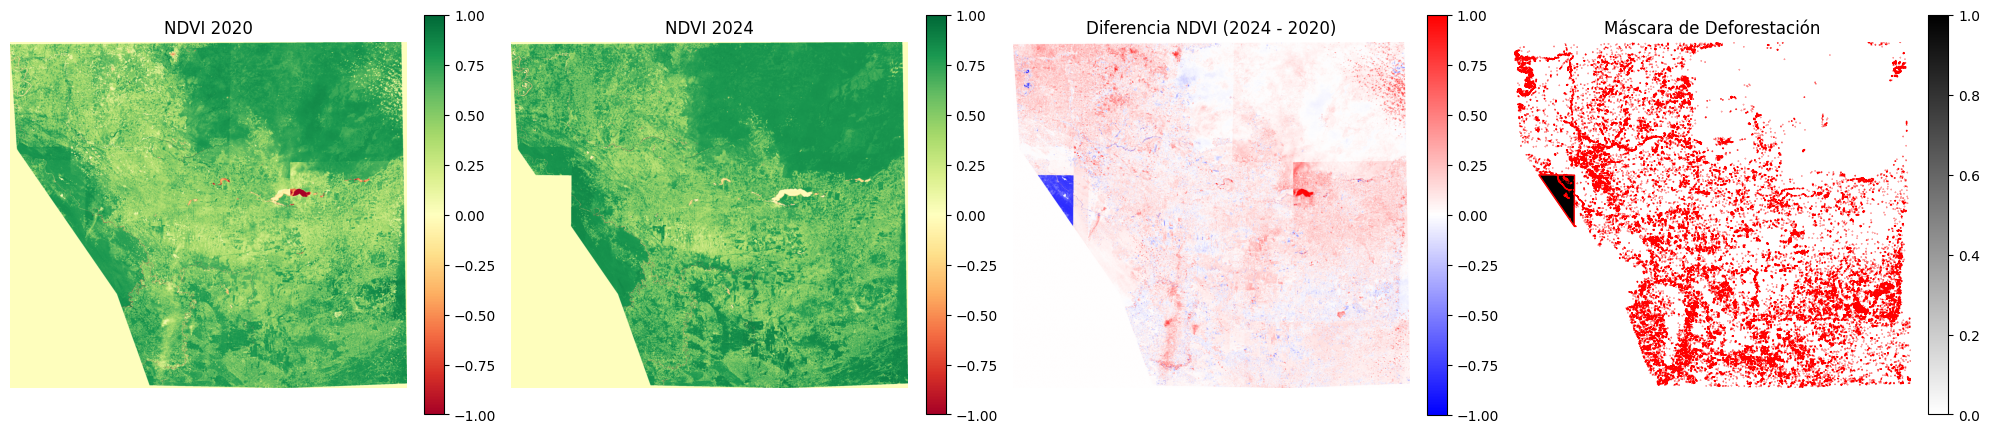

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Función para calcular NDVI evitando división por cero
def calc_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-6)

# Calcular NDVI para ambos años
ndvi_2020 = calc_ndvi(nir_2020, red_2020)
ndvi_2024 = calc_ndvi(nir_2024, red_2024)

# Imagen de diferencia
ndvi_diff = ndvi_2024 - ndvi_2020

# Máscara de deforestación (umbral < -0.2)
def_mask = ndvi_diff < -0.2

# Calcular porcentaje de deforestación
area_def_pct = np.sum(def_mask) / def_mask.size * 100

# Calcular área en hectáreas usando el tamaño del píxel
pixel_size_x = abs(profile['transform'][0])
pixel_size_y = abs(profile['transform'][4])
pixel_area_m2 = pixel_size_x * pixel_size_y

area_def_m2 = np.sum(def_mask) * pixel_area_m2
area_def_ha = area_def_m2 / 10000  # 1 hectárea = 10,000 m²

print(f"Tamaño del píxel en metros: {pixel_size_x:.4f} x {pixel_size_y:.4f}")
print(f"Área de un píxel (m²): {pixel_area_m2:.6f}")
print(f"Píxeles detectados con deforestación: {np.sum(def_mask)}")
print(f"Área total deforestada (m²): {area_def_m2:.6f}")
print(f"Área total deforestada (ha): {area_def_ha:.6f}")

print(f"Área de deforestación: {area_def_ha:.2f} hectáreas")
print(f"Porcentaje de deforestación: {area_def_pct:.2f}% del área analizada")

# Visualización
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# NDVI 2020
im0 = axs[0].imshow(ndvi_2020, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0].set_title('NDVI 2020')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# NDVI 2024
im1 = axs[1].imshow(ndvi_2024, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1].set_title('NDVI 2024')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Diferencia NDVI
im2 = axs[2].imshow(ndvi_diff, cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title('Diferencia NDVI (2024 - 2020)')
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

# Máscara de deforestación mejorada
im3 = axs[3].imshow(def_mask, cmap='gray_r', vmin=0, vmax=1)
axs[3].set_title('Máscara de Deforestación')
plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
# Contorno rojo sobre áreas deforestadas
axs[3].contour(def_mask, levels=[0.5], colors='red', linewidths=1)

# Quitar ejes
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import math

def deg2meters(lat, deg):
    # Aproximación del tamaño de un grado en metros en latitud dada
    m_per_deg_lat = 111132.92 - 559.82 * math.cos(2 * math.radians(lat)) + 1.175 * math.cos(4 * math.radians(lat))
    m_per_deg_lon = 111412.84 * math.cos(math.radians(lat)) - 93.5 * math.cos(3 * math.radians(lat))
    return deg * m_per_deg_lat, deg * m_per_deg_lon

In [5]:
dataset = rasterio.open(b04_2020)
profile = dataset.profile
bounds = dataset.bounds

pixel_deg_x = abs(profile['transform'][0])
pixel_deg_y = abs(profile['transform'][4])

lat_media = (bounds.top + bounds.bottom) / 2

pixel_m_y, pixel_m_x = deg2meters(lat_media, pixel_deg_x)
pixel_area_m2 = pixel_m_x * pixel_m_y

print(f"Tamaño del pixel aproximado en metros: {pixel_m_x:.6f} x {pixel_m_y:.6f} m")
print(f"Área del pixel aproximada: {pixel_area_m2:.6f} m²")

pixels_deforestados = np.sum(def_mask)

# Área total deforestada en m² y hectáreas
area_def_m2 = pixels_deforestados * pixel_area_m2
area_def_ha = area_def_m2 / 10000  # 1 ha = 10,000 m²
total_pixels = def_mask.size

print(f"Píxeles detectados con deforestación: {pixels_deforestados}")
print(f"Área total deforestada (ha): {area_def_ha:.4f}")
porcentaje_deforestacion = (pixels_deforestados / total_pixels) * 100
print(f"Porcentaje de deforestación: {porcentaje_deforestacion:.2f}%")

Tamaño del pixel aproximado en metros: 100.346614 x 104.212705 m
Área del pixel aproximada: 10457.392029 m²
Píxeles detectados con deforestación: 99373
Área total deforestada (ha): 103918.2418
Porcentaje de deforestación: 1.82%
